In [1]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy.contrasts import Diff
import scipy.stats as stats
import pandas as pd 
import numpy as np
import seaborn as sns

In [2]:
full_data = pd.read_csv('../data/regression_data.csv')
data = full_data.loc[(full_data.trial > 20) & (full_data.trial < 201)].copy()

In [3]:
# log transform initial movement vector/theta 
data['log_imv'] = np.log(data.initial_theta)
data

,trial,initial_theta,previous_uncertainty,midpoint_error,log_imv
21,21,4.610716,high_uncertainty,13.135877,1.528383
22,22,2.572146,high_uncertainty,9.289737,0.944740
23,23,3.949008,high_uncertainty,17.358585,1.373464
24,24,3.530292,unlimited_uncertainty,12.016481,1.261381
25,25,3.375517,no_uncertainty,5.595481,1.216549
...,...,...,...,...,...
196,196,6.594416,high_uncertainty,28.088958,1.886223
197,197,7.489401,unlimited_uncertainty,15.194057,2.013489
198,198,4.651564,low_uncertainty,19.618193,1.537204
199,199,4.755563,unlimited_uncertainty,21.945590,1.559315


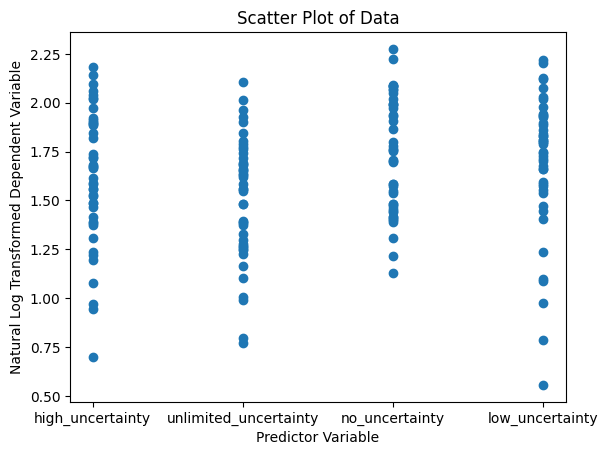

In [4]:
# Create a scatter plot of the transformed dependent variable vs. predictor variable(s)
plt.scatter(data['previous_uncertainty'], data['log_imv'])
plt.xlabel('Predictor Variable')
plt.ylabel('Natural Log Transformed Dependent Variable')
plt.title('Scatter Plot of Data')
plt.show()

In [5]:
data['z_score'] = (data['log_imv'] - data['log_imv'].mean()) / data['log_imv'].std()
outliers = data[np.abs(data['z_score']) > 3]

# 4 outliers (more than 3 sd) but only in the adaptation phase. 
outliers

,trial,initial_theta,previous_uncertainty,midpoint_error,log_imv,z_score
26,26,1.747769,low_uncertainty,20.92501,0.55834,-3.232399


In [6]:
#Remove outliers 
cleaned_data = data[np.abs(data['z_score']) <= 3].copy()

cleaned_data


,trial,initial_theta,previous_uncertainty,midpoint_error,log_imv,z_score
21,21,4.610716,high_uncertainty,13.135877,1.528383,-0.332659
22,22,2.572146,high_uncertainty,9.289737,0.944740,-2.077336
23,23,3.949008,high_uncertainty,17.358585,1.373464,-0.795756
24,24,3.530292,unlimited_uncertainty,12.016481,1.261381,-1.130807
25,25,3.375517,no_uncertainty,5.595481,1.216549,-1.264823
...,...,...,...,...,...,...
196,196,6.594416,high_uncertainty,28.088958,1.886223,0.737029
197,197,7.489401,unlimited_uncertainty,15.194057,2.013489,1.117462
198,198,4.651564,low_uncertainty,19.618193,1.537204,-0.306293
199,199,4.755563,unlimited_uncertainty,21.945590,1.559315,-0.240195


In [7]:
# calculate the change in IMV/initial theta from trial to the next trial and natural log transform
change_imv = np.diff(a=data.initial_theta, n=1, axis=-1, prepend=0)

data['log_change_imv'] = np.log(abs(change_imv))


In [8]:
# create formulas for regressions 
formula = 'log_imv ~ trial + C(previous_uncertainty, Diff) * midpoint_error + 1'
formula_2 = 'log_change_imv ~ C(previous_uncertainty, Diff) * midpoint_error + 1 '

### Regression 1: 
Regresses initial movement vector (initial_theta) on midpoint error (midpoint_error), trial (log_trial) and midpoint sensory uncertainty on the previous trial (previous_uncertainty) as well as the interaction between midpoint error and uncertainty on the previous trial. 

In [9]:
# Regression 1 
# Create and train the linear regression model with statsmodels
model = smf.ols(formula, data=data)

# fit the model 
reg = model.fit()

# Get the summary of the regression model, including p-values
summary = reg.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                log_imv   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     2.611
Date:                Tue, 12 Sep 2023   Prob (F-statistic):             0.0101
Time:                        20:15:40   Log-Likelihood:                -47.428
No. Observations:                 180   AIC:                             112.9
Df Residuals:                     171   BIC:                             141.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

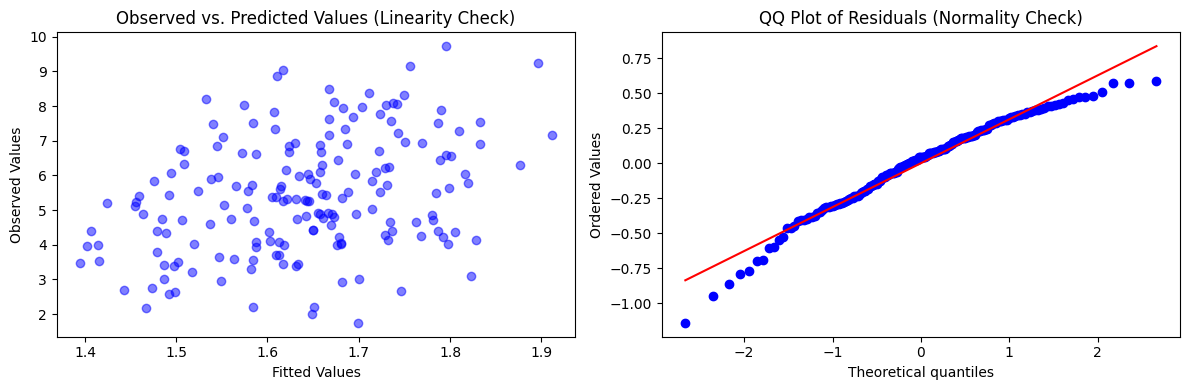

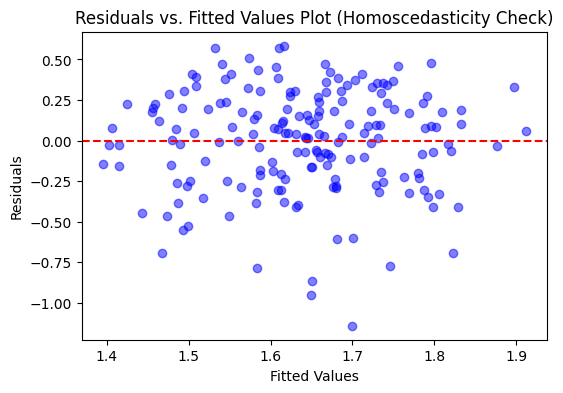

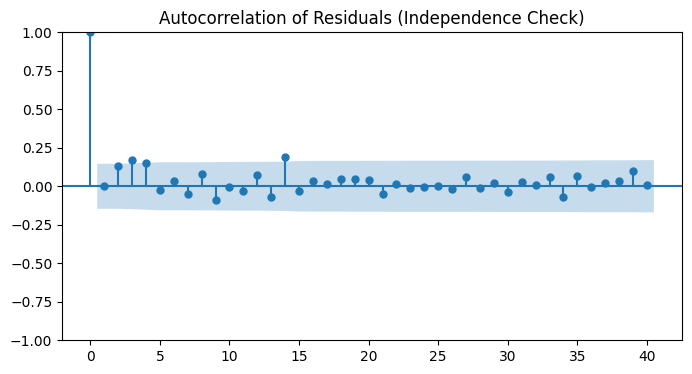

                                            Variable        VIF
0                                          Intercept  18.524875
1  C(previous_uncertainty, Diff)[D.high_uncertainty]  29.448346
2   C(previous_uncertainty, Diff)[D.low_uncertainty]  33.526558
3    C(previous_uncertainty, Diff)[D.no_uncertainty]  21.895836
4                                              trial   1.092703
5                                     midpoint_error   1.107345
6  C(previous_uncertainty, Diff)[D.high_uncertain...  28.428192
7  C(previous_uncertainty, Diff)[D.low_uncertaint...  31.793278
8  C(previous_uncertainty, Diff)[D.no_uncertainty...  21.252840


In [10]:
residuals = reg.resid
fitted_values = reg.fittedvalues

# Linearity Check (Observed vs. Predicted)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(fitted_values, data['initial_theta'], color='blue', alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Observed Values')
plt.title('Observed vs. Predicted Values (Linearity Check)')

# Normality of Residuals (QQ Plot)
plt.subplot(1, 2, 2)
stats.probplot(residuals, plot=plt)
plt.title('QQ Plot of Residuals (Normality Check)')

plt.tight_layout()
plt.show()

# Homoscedasticity Check (Residuals vs. Fitted Values)
plt.figure(figsize=(6, 4))
plt.scatter(fitted_values, residuals, color='blue', alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values Plot (Homoscedasticity Check)')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Independence of Residuals (Autocorrelation Plot)
fig, ax = plt.subplots(figsize=(8, 4))
sm.graphics.tsa.plot_acf(residuals, ax=ax, lags=40)
plt.title('Autocorrelation of Residuals (Independence Check)')
plt.show()

# Multicollinearity Check (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = reg.model.data.orig_exog
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)



### Regression 2 
Regresses **change** in IMV (between trials) on midpoint error and midpoint sensory uncertainty on the previous trial as well as the interaction between midpoint error and uncertainty on the previous trial. 

In [11]:
# Regression 2
# Create and train the linear regression model with statsmodels
model_2 = smf.ols(formula_2, data=data)

# fit the model 
reg_2 = model_2.fit()

# Get the summary of the regression model, including p-values
summary_2 = reg_2.summary()
print(summary_2)

                            OLS Regression Results                            
Dep. Variable:         log_change_imv   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.4684
Date:                Tue, 12 Sep 2023   Prob (F-statistic):              0.856
Time:                        20:15:41   Log-Likelihood:                -258.11
No. Observations:                 180   AIC:                             532.2
Df Residuals:                     172   BIC:                             557.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

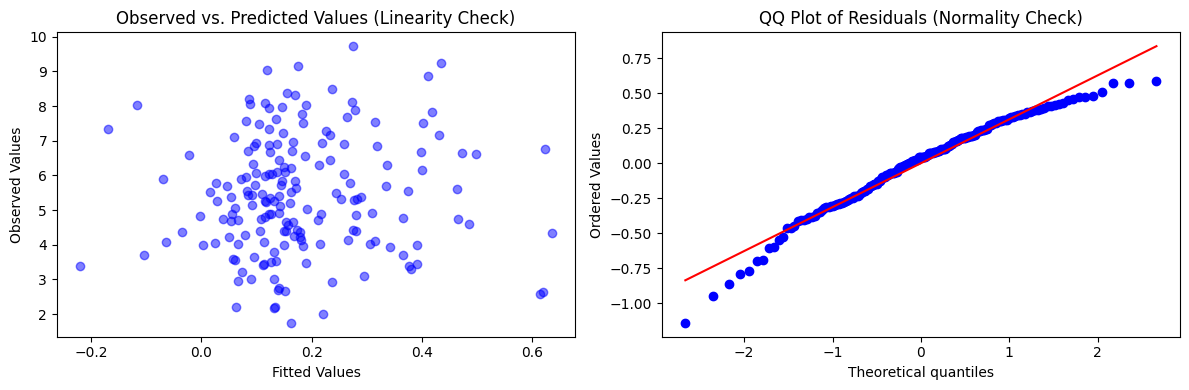

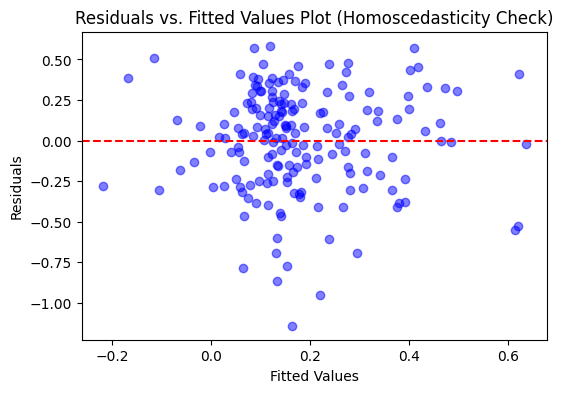

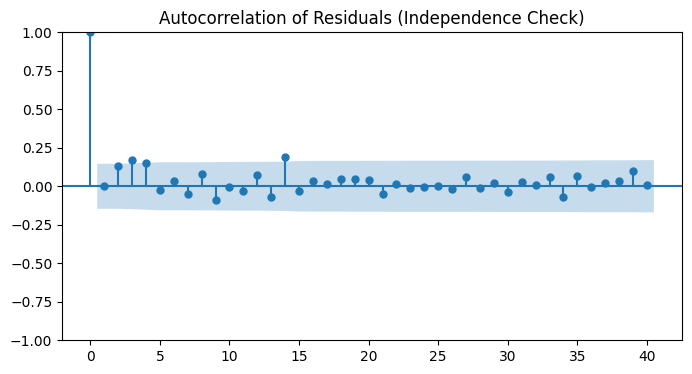

                                            Variable        VIF
0                                          Intercept  18.524875
1  C(previous_uncertainty, Diff)[D.high_uncertainty]  29.448346
2   C(previous_uncertainty, Diff)[D.low_uncertainty]  33.526558
3    C(previous_uncertainty, Diff)[D.no_uncertainty]  21.895836
4                                              trial   1.092703
5                                     midpoint_error   1.107345
6  C(previous_uncertainty, Diff)[D.high_uncertain...  28.428192
7  C(previous_uncertainty, Diff)[D.low_uncertaint...  31.793278
8  C(previous_uncertainty, Diff)[D.no_uncertainty...  21.252840


In [12]:
#assumption testing 
residuals_2 = reg_2.resid
fitted_values = reg_2.fittedvalues

# Linearity Check (Observed vs. Predicted)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(fitted_values, data['initial_theta'], color='blue', alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Observed Values')
plt.title('Observed vs. Predicted Values (Linearity Check)')

# Normality of Residuals (QQ Plot)
plt.subplot(1, 2, 2)
stats.probplot(residuals, plot=plt)
plt.title('QQ Plot of Residuals (Normality Check)')

plt.tight_layout()
plt.show()

# Homoscedasticity Check (Residuals vs. Fitted Values)
plt.figure(figsize=(6, 4))
plt.scatter(fitted_values, residuals, color='blue', alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values Plot (Homoscedasticity Check)')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Independence of Residuals (Autocorrelation Plot)
fig, ax = plt.subplots(figsize=(8, 4))
sm.graphics.tsa.plot_acf(residuals, ax=ax, lags=40)
plt.title('Autocorrelation of Residuals (Independence Check)')
plt.show()

# Multicollinearity Check (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = reg.model.data.orig_exog
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


### Repeated Measures / Paired T-test 
Compares the last 3 trials of the adaptaiton phase (trial 198 to 200) and the first 3 trials of the washout phase (trial 201 to 203). 

In [13]:
# ttest 
adaptation = full_data.loc[(full_data.trial <= 200) & (full_data.trial >= 198)]
washout = full_data.loc[(full_data.trial >= 201) & (full_data.trial <= 203)]


In [14]:
#manual checking of last 3 adapation trials
full_data.loc[(full_data.trial <= 200) & (full_data.trial >= 198)]

,trial,initial_theta,previous_uncertainty,midpoint_error
198,198,4.651564,low_uncertainty,19.618193
199,199,4.755563,unlimited_uncertainty,21.945590
200,200,7.327837,no_uncertainty,7.202566


In [15]:
#manual checking of first 3 washout trials
full_data.loc[(full_data.trial >= 201) & (full_data.trial <= 203)]

,trial,initial_theta,previous_uncertainty,midpoint_error
201,201,4.304293,unlimited_uncertainty,4.532179
202,202,3.421305,unlimited_uncertainty,3.806629
203,203,3.387373,unlimited_uncertainty,2.733965


In [16]:
stats.ttest_rel(adaptation.initial_theta, washout.initial_theta)

TtestResult(statistic=1.7484626097445586, pvalue=0.22249237711478717, df=2)

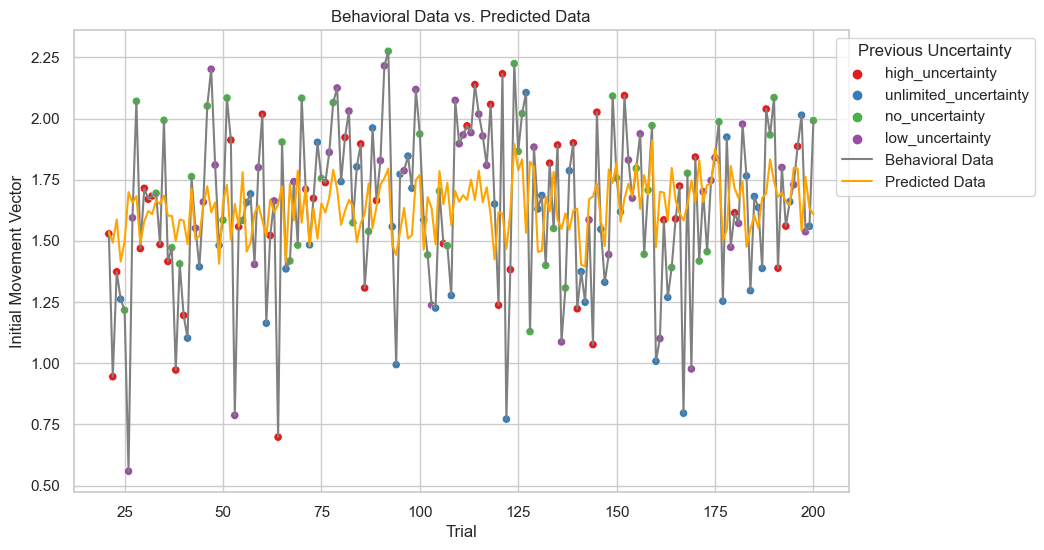

In [17]:
x = data.trial

# Predict (log)IMV for regression model 1 (reg)
predicted_initial_theta = reg.predict(data)

# style and size
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create a color palette based on previous_uncertainty levels
palette = sns.color_palette("Set1", n_colors=len(data['previous_uncertainty'].unique()))

# Create a scatter plot for color-coding the behavioral data points
sns.scatterplot(x="trial", y="log_imv", hue="previous_uncertainty", data=data, palette=palette, legend=True)

# Plot the behavioral data as a line
sns.lineplot(x="trial", y="log_imv", data=data, color='grey', label='Behavioral Data')

# Plot the predicted initial_theta from the regression model
plt.plot(x, predicted_initial_theta, label='Predicted Data', linestyle='-', color='orange')

# Labels
plt.xlabel('Trial')
plt.ylabel('Initial Movement Vector')
plt.title('Behavioral Data vs. Predicted Data')
plt.legend()
plt.grid(True)

# Show the legend
plt.legend(title="Previous Uncertainty", bbox_to_anchor= (1.25,1), loc='upper right')



Text(0.5, 1.0, 'Distribution of Mean Changes in Initial Movement Vector by Uncertainty Level')

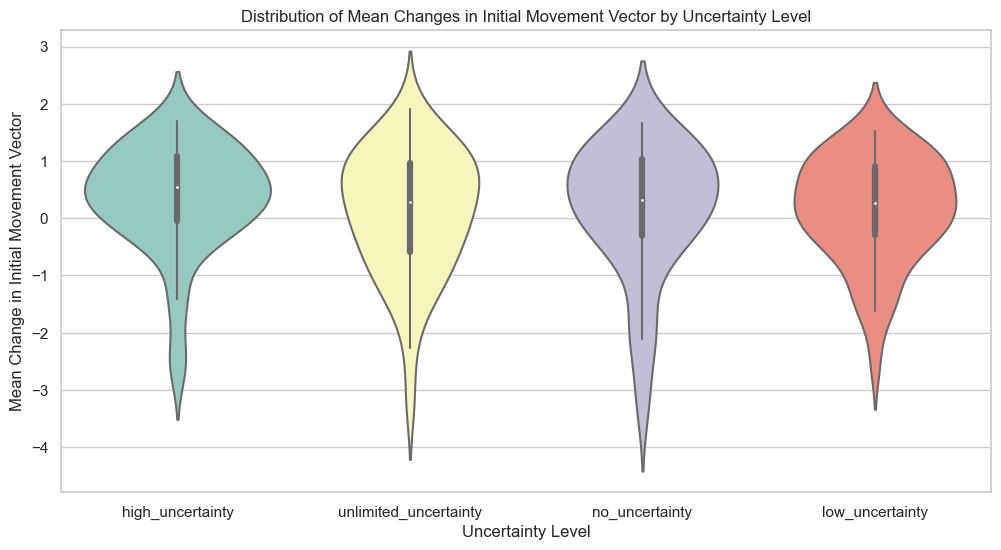

In [18]:
# Set the style and size of the plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Create the Violin plot
sns.violinplot(x="previous_uncertainty", y="log_change_imv", data=data, inner="box", palette="Set3")

# labels and title
plt.xlabel("Uncertainty Level")
plt.ylabel("Mean Change in Initial Movement Vector")
plt.title("Distribution of Mean Changes in Initial Movement Vector by Uncertainty Level")


Text(0.5, 1.0, 'Mean Change in Initial Movement Vector vs. Midpoint Error')

<Figure size 1200x600 with 0 Axes>

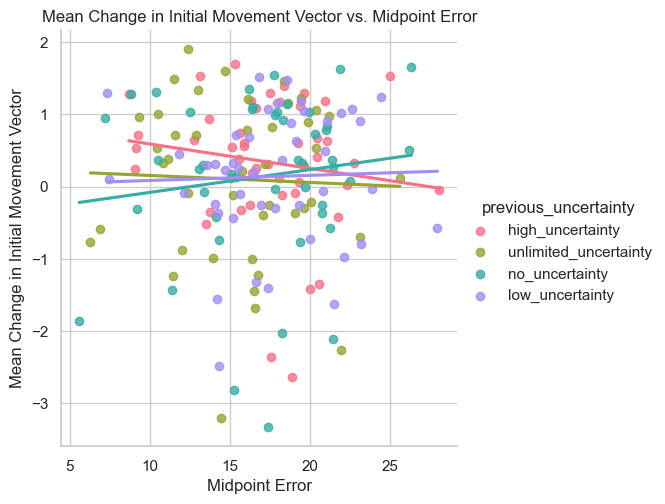

In [19]:
# Set the style and size of the plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Create a scatter plot with regression lines
sns.lmplot(x="midpoint_error", y="log_change_imv", hue="previous_uncertainty", data=data, ci=None, palette="husl")

# Add labels and title
plt.xlabel("Midpoint Error")
plt.ylabel("Mean Change in Initial Movement Vector")
plt.title("Mean Change in Initial Movement Vector vs. Midpoint Error")



In [20]:
# full_data['log_imv'] = np.log(full_data.initial_theta)
# full_data['z_score'] = (full_data['log_imv'] - full_data['log_imv'].mean()) / full_data['log_imv'].std()
# cleaned_data = full_data[np.abs(full_data['z_score']) <= 3].copy()

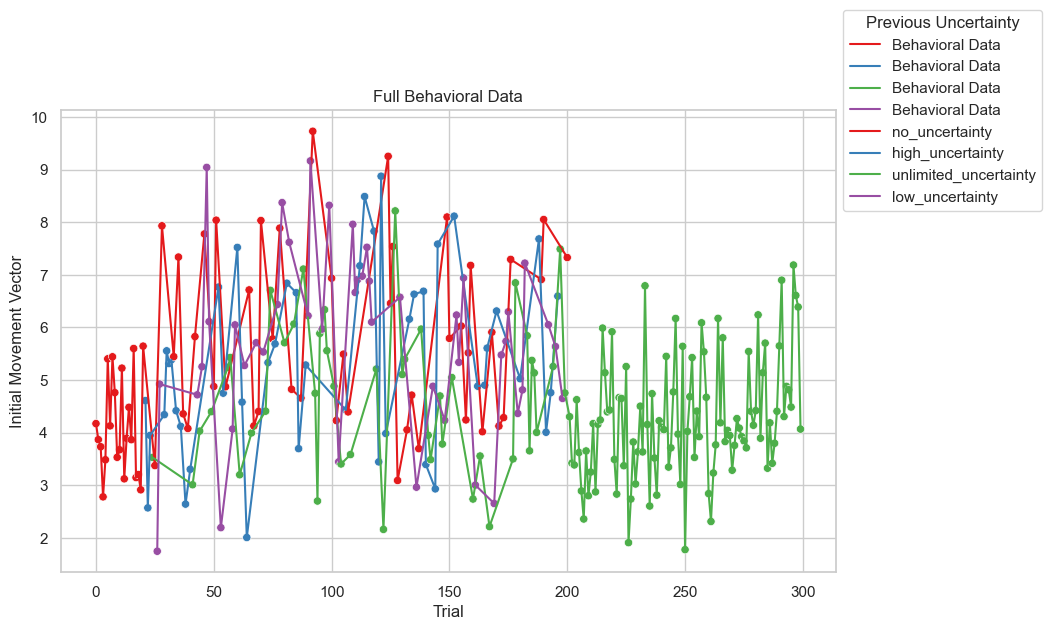

In [42]:
plt.figure(figsize=(10, 6))
# Create a color palette based on previous_uncertainty levels
palette = sns.color_palette("Set1", n_colors=len(full_data['previous_uncertainty'].unique()))

# Plot the behavioral data as a line
sns.lineplot(x="trial", y="initial_theta", data=full_data, hue='previous_uncertainty', palette=palette, label='Behavioral Data')

# Create a scatter plot for color-coding the behavioral data points
sns.scatterplot(x="trial", y="initial_theta", hue="previous_uncertainty", data=full_data, palette=palette, legend=False)
# Labels
plt.xlabel('Trial')
plt.ylabel('Initial Movement Vector')
plt.title('Full Behavioral Data')
plt.legend(title="Previous Uncertainty", bbox_to_anchor=(1, 1), loc='center left')
plt.grid(True)


In [22]:
endpoint = pd.read_csv('../data/endpoint_theta.csv')

In [23]:
endpoint

,Unnamed: 0,trial,endpoint_theta,no_uncertainty,low_uncertainty,high_uncertainty,unlimited_uncertainty,previous_uncertainty
0,0,0,1.571189,0.0,0.0,0.0,0.0,baseline_no_uncertainty
1,1,1,1.401198,0.0,0.0,0.0,0.0,baseline_no_uncertainty
2,2,2,0.355522,0.0,0.0,0.0,0.0,baseline_no_uncertainty
3,3,3,0.829138,0.0,0.0,0.0,0.0,baseline_no_uncertainty
4,4,4,0.758961,0.0,0.0,0.0,0.0,baseline_no_uncertainty
...,...,...,...,...,...,...,...,...
295,295,295,1.122190,0.0,0.0,0.0,0.0,washout_unlimited_uncertainty
296,296,296,1.892978,0.0,0.0,0.0,0.0,washout_unlimited_uncertainty
297,297,297,1.282256,0.0,0.0,0.0,0.0,washout_unlimited_uncertainty
298,298,298,1.548379,0.0,0.0,0.0,0.0,washout_unlimited_uncertainty


In [24]:
# endpoint['log_emv'] = np.log(endpoint.endpoint_theta)

# endpoint['z_score'] = (endpoint['log_emv'] - endpoint['log_emv'].mean()) / endpoint['log_emv'].std()
# endpoint_outliers = endpoint[np.abs(endpoint['z_score']) > 3]

# endpoint_cleaned_data = endpoint[np.abs(endpoint['z_score']) <= 3].copy()

# endpoint_outliers #3 outliers (trial 9, 269 and 277)

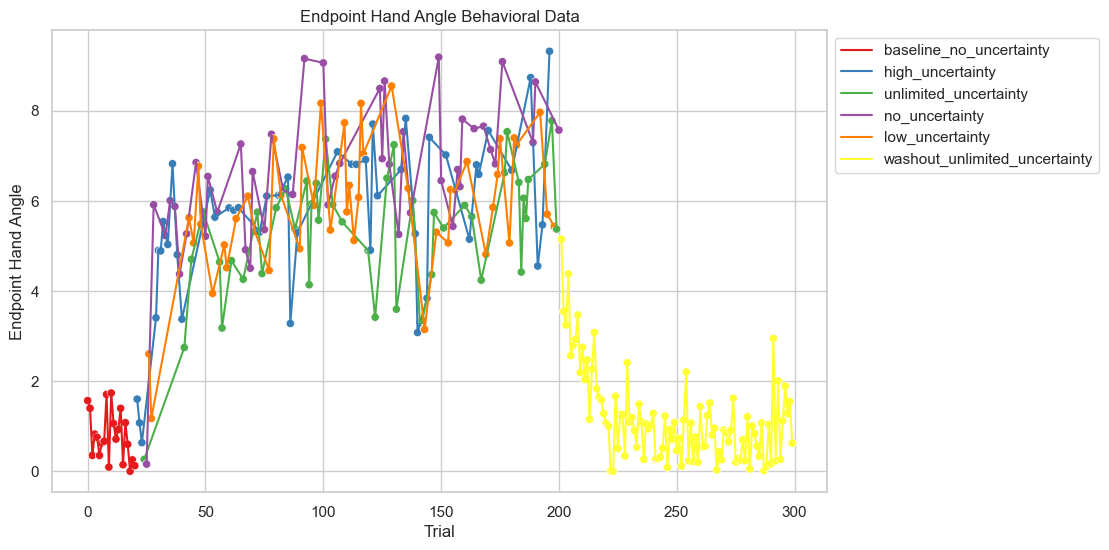

In [39]:
plt.figure(figsize=(10, 6))

# Create a color palette based on previous_uncertainty levels
palette = sns.color_palette("Set1", n_colors=(len(full_data['previous_uncertainty'].unique()) +2))

# Plot the behavioral data as a line
sns.lineplot(x="trial", y="endpoint_theta", data=endpoint, hue='previous_uncertainty', palette=palette)

# Create a scatter plot for color-coding the behavioral data points
sns.scatterplot(x="trial", y="endpoint_theta", hue="previous_uncertainty", data=endpoint, palette=palette, legend=False)
# Labels
plt.xlabel('Trial')
plt.ylabel('Endpoint Hand Angle')
plt.title('Endpoint Hand Angle Behavioral Data')
plt.legend(bbox_to_anchor=(1 ,1))
plt.grid(True)
